<a href="https://colab.research.google.com/github/arielwendichansky/DI_Bootcamp/blob/master/Week6/Day5/Daily_challenge/Comprehensive_Mobile_Price_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats, cluster
from scipy.optimize import minimize_scalar
from scipy.stats import skew, kurtosis, median_test,ttest_ind, norm
from scipy.stats import describe
from plotnine import (ggplot,aes,geom_line,facet_wrap,labs, scale_x_datetime, element_text, theme_538)
from plotnine.data import meat
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, recall_score
from collections import Counter


# Extract info Kaggle

In [49]:
! pip install -k kaggle
from google.colab import files
files.upload()


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -k


{}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d iabhishekofficial/mobile-price-classification

In [ ]:
! unzip 'mobile-price-classification.zip'

Archive:  mobile-price-classification.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [53]:
df = pd.read_csv('train.csv')

#Data inspection

In [54]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

The dataset looks clean, there're no missing values plus no type that needs to be changed

In [56]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


Evaluating the mean for each feature and the 50%, both looks close, meaning there're high chances to not find any outlier.

In [57]:
df.duplicated().sum()

0

There are no duplicates rows

In [58]:
for col in df.columns:
  print(col)
  print(describe(df[col]))

battery_power
DescribeResult(nobs=2000, minmax=(501, 1998), mean=1238.5185, variance=193088.35983766886, skewness=0.03187454295305568, kurtosis=-1.224084165725428)
blue
DescribeResult(nobs=2000, minmax=(0, 1), mean=0.495, variance=0.2501000500250125, skewness=0.02000100007500624, kurtosis=-1.9995999599959997)
clock_speed
DescribeResult(nobs=2000, minmax=(0.5, 3.0), mean=1.52225, variance=0.6658628689344673, skewness=0.17795052935349268, kurtosis=-1.3231094949498647)
dual_sim
DescribeResult(nobs=2000, minmax=(0, 1), mean=0.5095, variance=0.2500347673836919, skewness=-0.03800686085763292, kurtosis=-1.9985554785277484)
fc
DescribeResult(nobs=2000, minmax=(0, 19), mean=4.3095, variance=18.84813381690845, skewness=1.0190463925723268, kurtosis=0.27338561771466496)
four_g
DescribeResult(nobs=2000, minmax=(0, 1), mean=0.5215, variance=0.24966258129064536, skewness=-0.08607961742649396, kurtosis=-1.9925902994637084)
int_memory
DescribeResult(nobs=2000, minmax=(2, 64), mean=32.0465, variance=329

# Hypothesis testing

* H1 - There is a statistical significance between price groups
* H0 - There isn't a statistical significance between price groups




In [59]:
df['price_range'].unique()

array([1, 2, 3, 0])

In [60]:
price= df.groupby('price_range')

price_0 = price.get_group(0)
price_1 = price.get_group(1)
price_2 = price.get_group(2)
price_3 = price.get_group(3)


In [61]:
alpha = 0.05

# Perform ANOVA test
f_statistic, p_value = stats.f_oneway(price_0['ram'], price_1['ram'], price_2['ram'], price_3['ram'])

print("F-statistic:", f_statistic, "p-value:", p_value)

# Check if the p-value is less than or equal to alpha
if p_value <= alpha:
    decision = "Reject"
else:
    decision = "Fail to reject"

print("Decision:", decision)

F-statistic: 3520.110823895761 p-value: 0.0
Decision: Reject


Based on the p value, it is possible to interpret this is extremely small, indicating strong evidence against the null hypothesis. This would lead to reject the null hypothesis and conclude that there is a statistically significant difference among the price groups.

# Exploratory Data Analysis

Text(0.5, 0.93, 'Features Distribution')

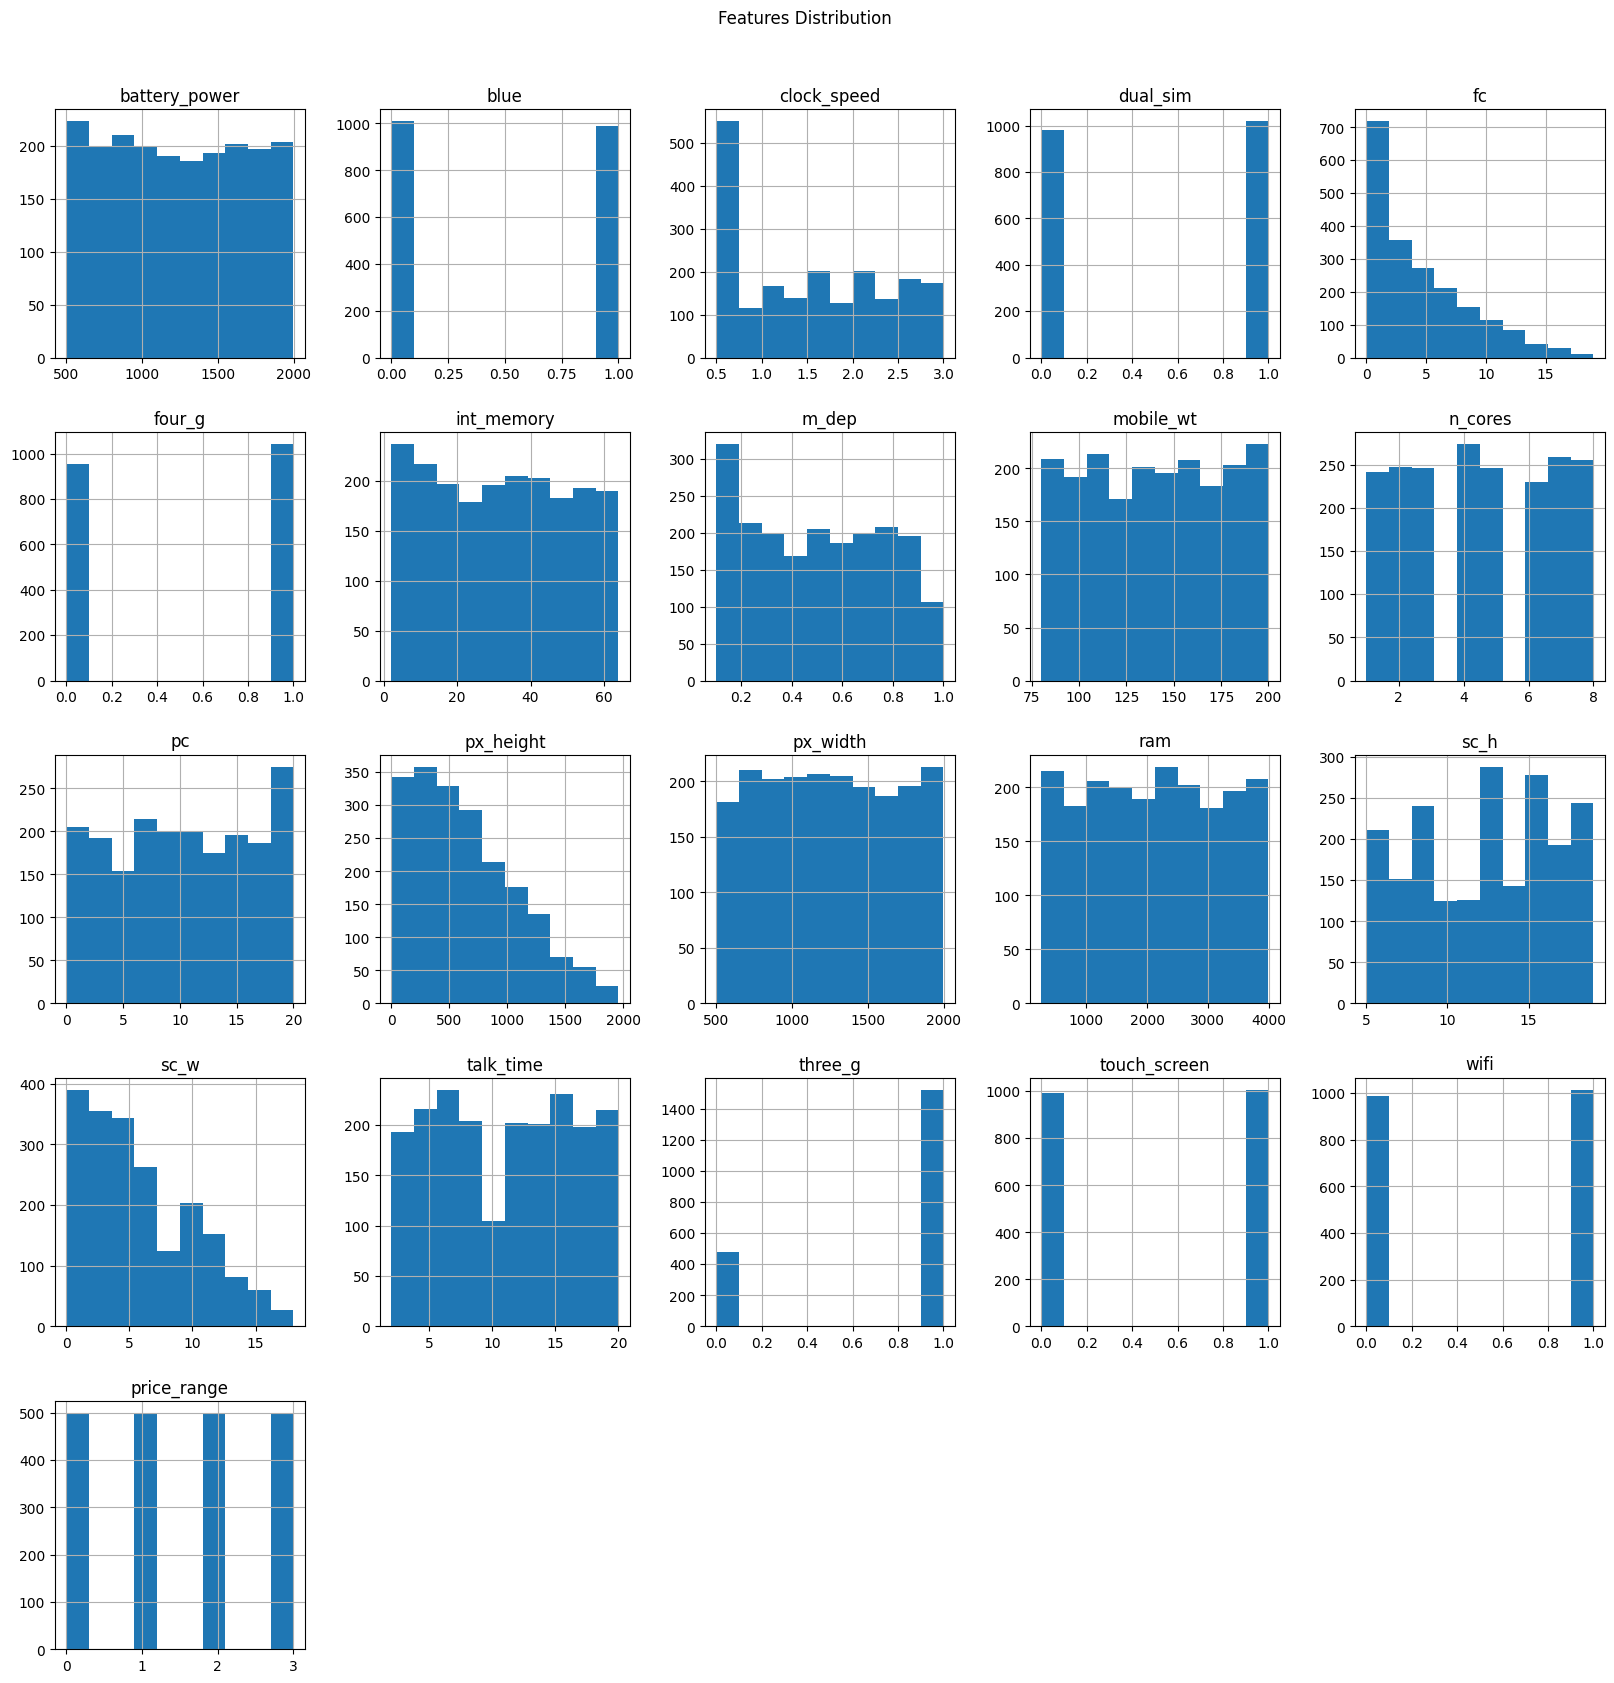

In [62]:
df.hist(figsize=(20,20))

plt.suptitle('Features Distribution', y= 0.93)



In [63]:
numeric_columns = [ "battery_power", "clock_speed", "fc","int_memory","m_dep", "mobile_wt","n_cores","pc","px_height",
    "px_width", "ram","sc_h", "sc_w","talk_time"]

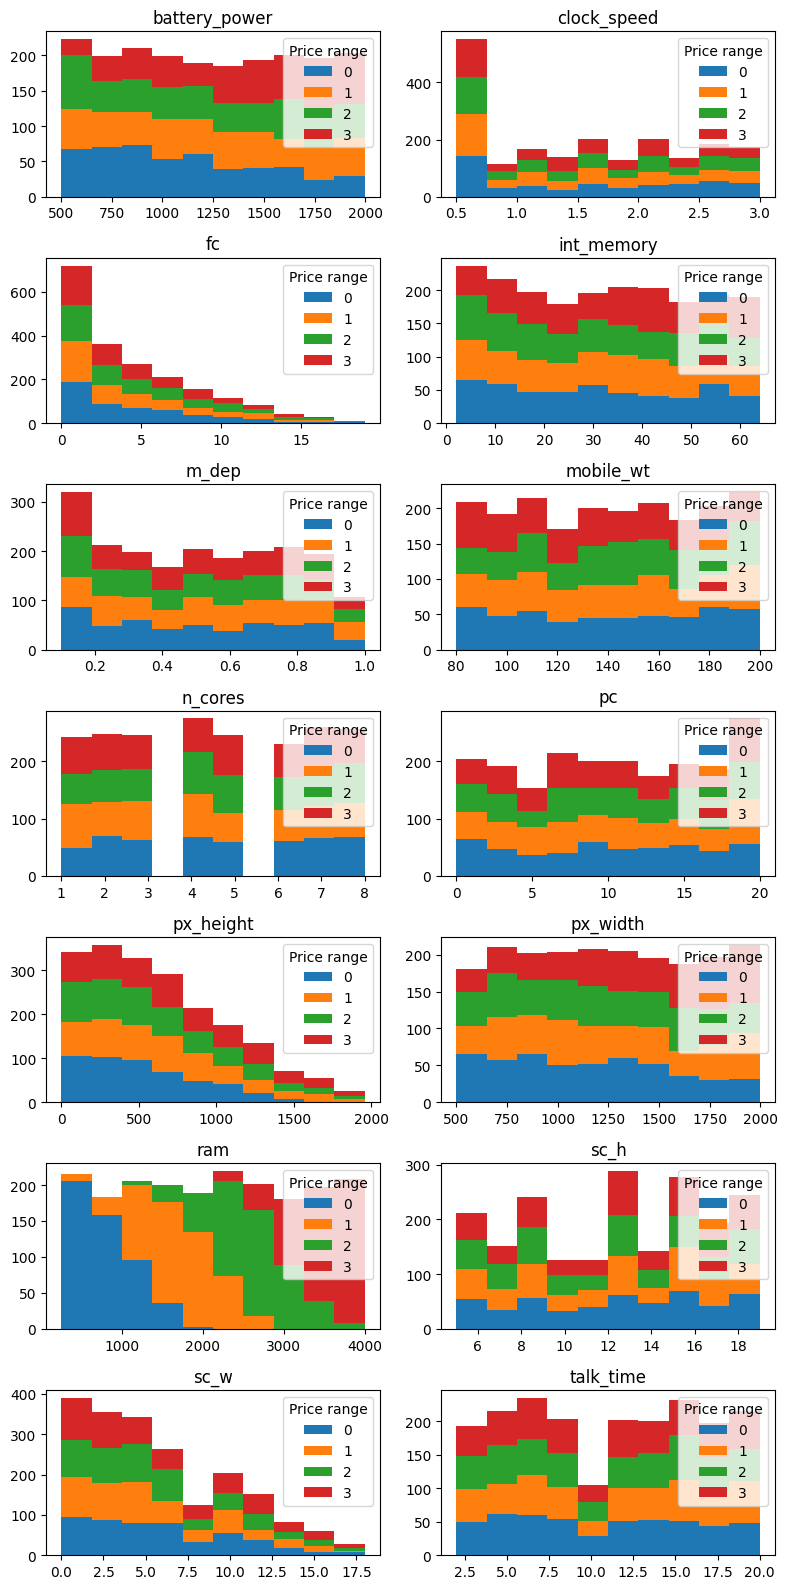

In [64]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(8, 16))
axes = axes.flatten()
data_by_price_range = df.groupby("price_range", observed=True)

for ax, column_name in zip(axes, numeric_columns):
    ax.hist([x[1][column_name] for x in data_by_price_range], stacked=True, label=[x[0] for x in data_by_price_range])
    ax.set_title(column_name)
    ax.legend(title="Price range", loc="upper right")

fig.tight_layout()
fig.show()

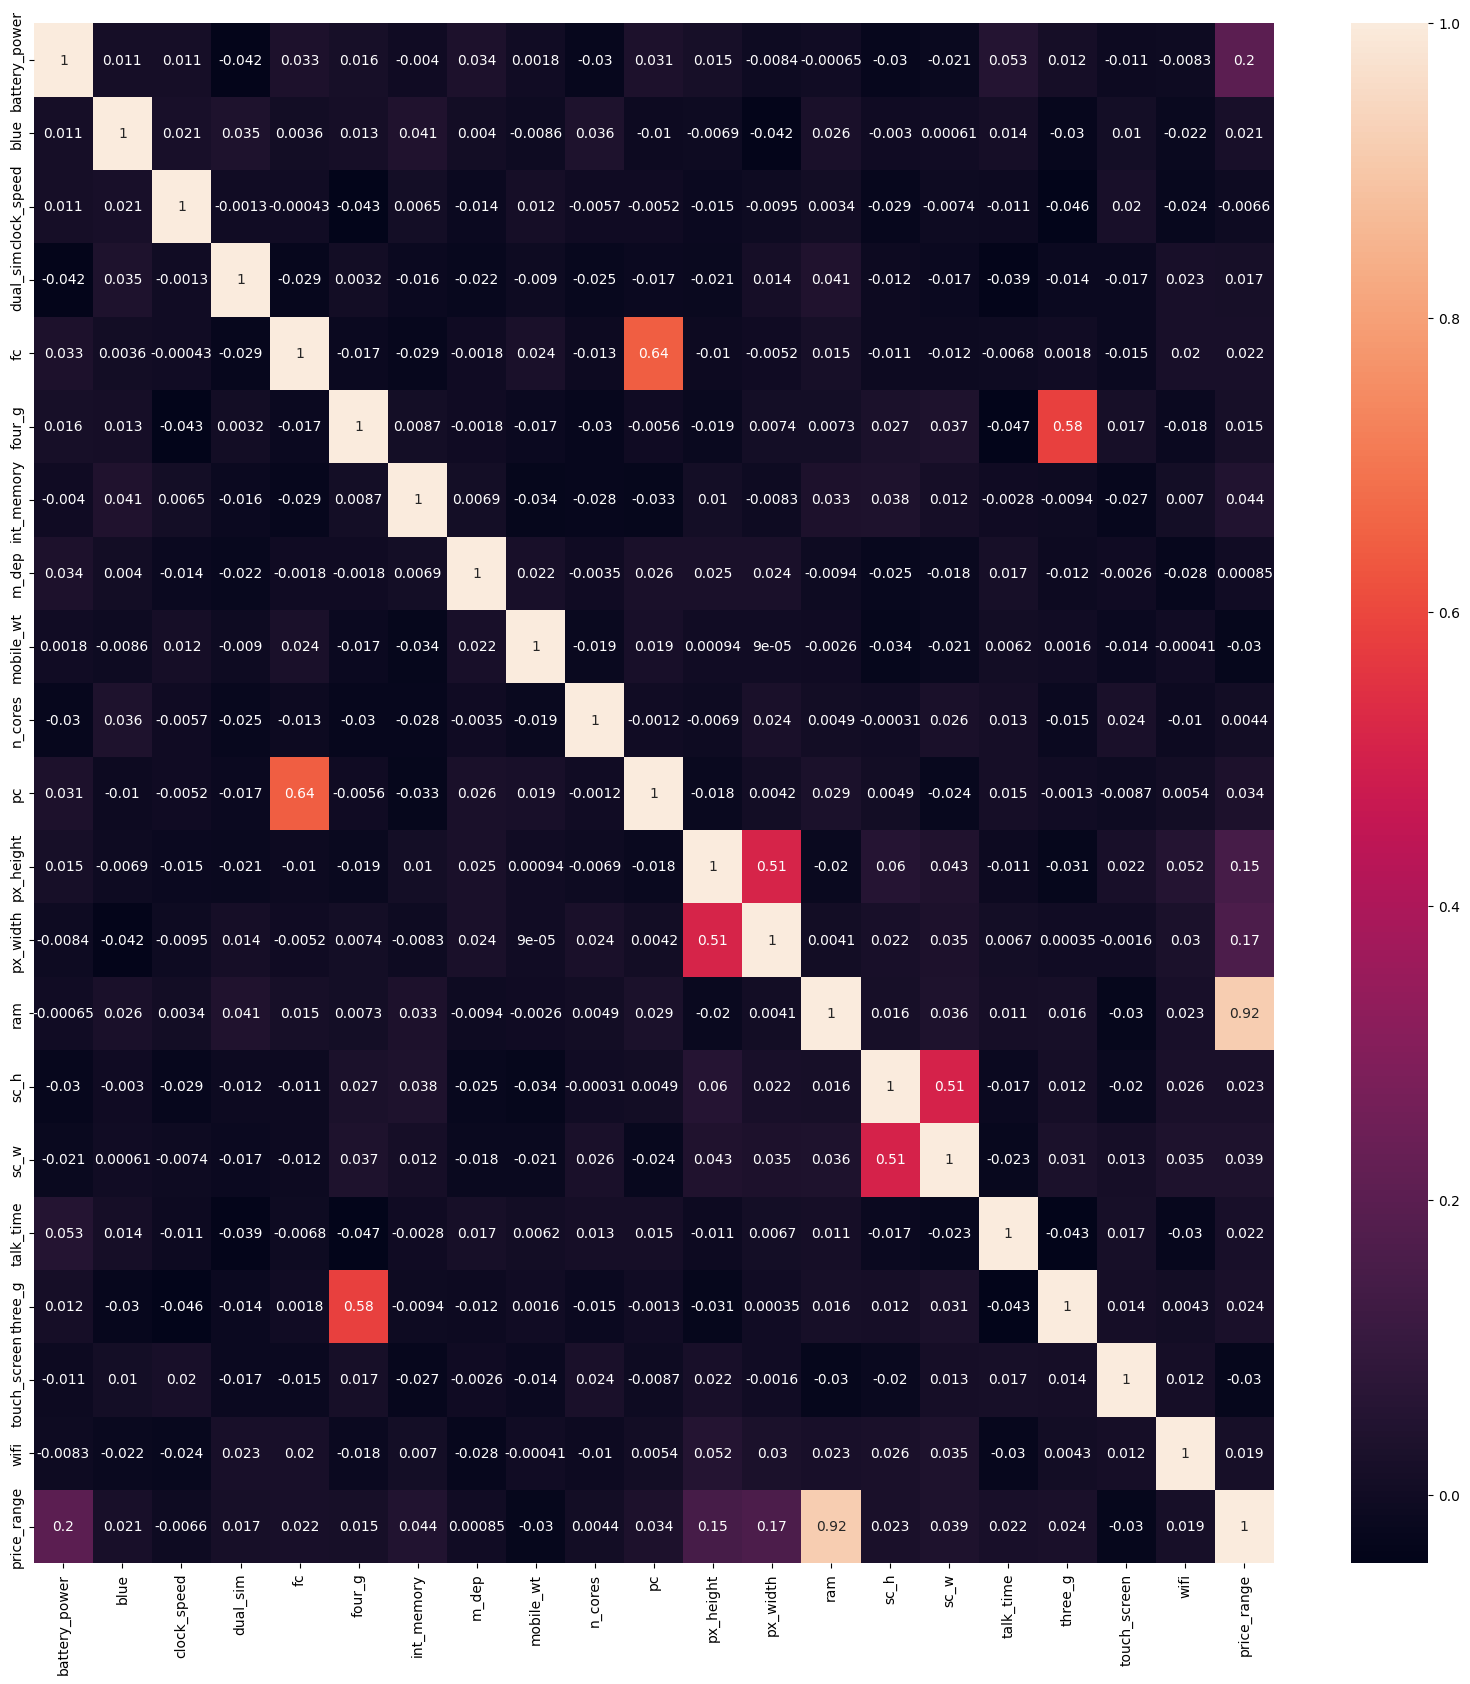

In [65]:
sns.heatmap(df.corr(),annot=True)

plt.rcParams['figure.figsize']=(20,20);

In terms of price range, there exists a strong positive correlation with the phone's memory RAM, indicating that phones with higher RAM tend to be more expensive. Additionally, there is a correlation between the battery capacity and camera quality of the phone, highlighting the importance of these features in determining the phone's price. However, it's worth noting that their influence on price is not as significant as that of RAM.

Additionally, we observe a correlation between the quality of the front and rear cameras, suggesting that a high-quality front camera often coincides with a high-quality rear camera.

Finally, if a phone supports 4G connectivity, there is a strong correlation indicating it may also support 3G connectivity.